In [ ]:
pip install yahoofinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of tickers
tickers = ["NVDA", "MSFT", "AAPL", "AMZN", "AVGO", "META", "GOOGL", "TSLA", "GOOG", "LLY"]

# Download 3 months of daily data
data = yf.download(tickers, period="3mo", interval="1d")

# Use 'Close' data
close_data = data["Close"]

# Compute daily % change
daily_returns = close_data.pct_change() * 100

# Compute rolling 20-day volatility (annualized)
# Fill NaN with first available rolling value per ticker
rolling_volatility = (
    daily_returns.rolling(window=20, min_periods=10).std() * np.sqrt(252)
).fillna(method="bfill")

# Get beta values from Yahoo
beta_values = {t: yf.Ticker(t).info.get("beta", None) for t in tickers}

# Reshape to tidy format
df_prices = close_data.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Price")
df_returns = daily_returns.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Daily_Change_%")
df_vol = rolling_volatility.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="RollingVol_%")

# Merge everything
merged = (
    df_prices
    .merge(df_returns, on=["Date", "Ticker"], how="left")
    .merge(df_vol, on=["Date", "Ticker"], how="left")
)

# Add beta values
merged["Beta"] = merged["Ticker"].map(beta_values)

# Drop rows where data is missing for regression
merged = merged.dropna(subset=["Price", "Daily_Change_%", "RollingVol_%"]).reset_index(drop=True)

print("✅ Regression-ready dataset (sample):")
print(merged.head(10))

# Optional: save to CSV
merged.to_csv("stock_regression_ready.csv", index=False)


/tmp/ipython-input-260221409.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="3mo", interval="1d")
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-260221409.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method="bfill")


✅ Regression-ready dataset (sample):
        Date Ticker       Price  Daily_Change_%  RollingVol_%   Beta
0 2025-07-22   AAPL  214.156952        0.903618     15.665501  1.094
1 2025-07-23   AAPL  213.907227       -0.116609     15.665501  1.094
2 2025-07-24   AAPL  213.517670       -0.182115     15.665501  1.094
3 2025-07-25   AAPL  213.637543        0.056142     15.665501  1.094
4 2025-07-28   AAPL  213.807358        0.079487     15.665501  1.094
5 2025-07-29   AAPL  211.030502       -1.298765     15.665501  1.094
6 2025-07-30   AAPL  208.813019       -1.050788     15.665501  1.094
7 2025-07-31   AAPL  207.334702       -0.707962     15.665501  1.094
8 2025-08-01   AAPL  202.150589       -2.500359     15.665501  1.094
9 2025-08-04   AAPL  203.119492        0.479297     15.665501  1.094


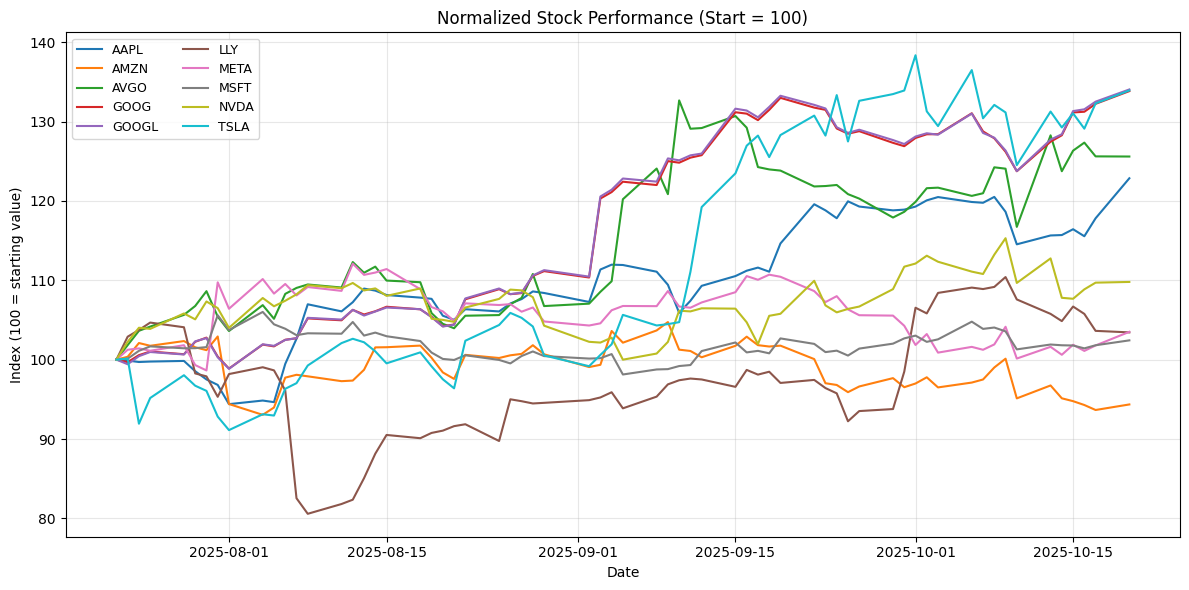

In [3]:
# Normalize prices to start at 100
# Pivot data to wide format for plotting
price_pivot = merged.pivot(index="Date", columns="Ticker", values="Price")

normalized = price_pivot / price_pivot.iloc[0] * 100

plt.figure(figsize=(12, 6))
for ticker in normalized.columns:
    plt.plot(normalized.index, normalized[ticker], label=ticker)

plt.title("Normalized Stock Performance (Start = 100)")
plt.xlabel("Date")
plt.ylabel("Index (100 = starting value)")
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

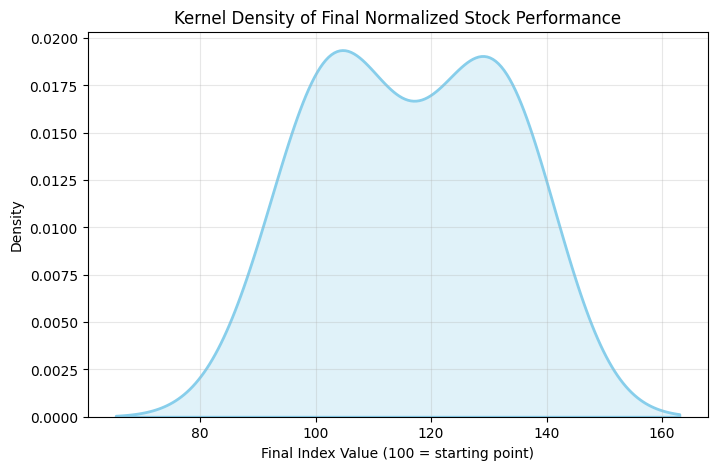

In [5]:
# Option 1: KDE of final normalized values (e.g., final performance)
final_values = normalized.iloc[-1]

plt.figure(figsize=(8, 5))
sns.kdeplot(final_values, fill=True, color="skyblue", linewidth=2)
plt.title("Kernel Density of Final Normalized Stock Performance")
plt.xlabel("Final Index Value (100 = starting point)")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()